In [1]:
import os
import sys

from fastai.vision.all import *


sys.path.append('..') # <-- relative path of utils library

from utils import cross_validation, test_split, common
from utils.fastai_utils import MLFlowExperiment
from utils.fastai_train import fold_gen, train, get_train_val_indices, get_test_indices

plt.rcParams['figure.figsize'] = [12, 8]

In [2]:
DATA_PARAMS = {
    'NUM_K_FOLDS': 5,
    'BASE_DATA_DIR': '../data/metadata',
    'OUTPUT_PATH': '../data/metadata',
    'SPECTROGRAM_DIR' :  "../data/metadata/spectrograms",
    'SEED': 200  
}
 

In [3]:
path = Path(".")
Path.BASE_PATH = path

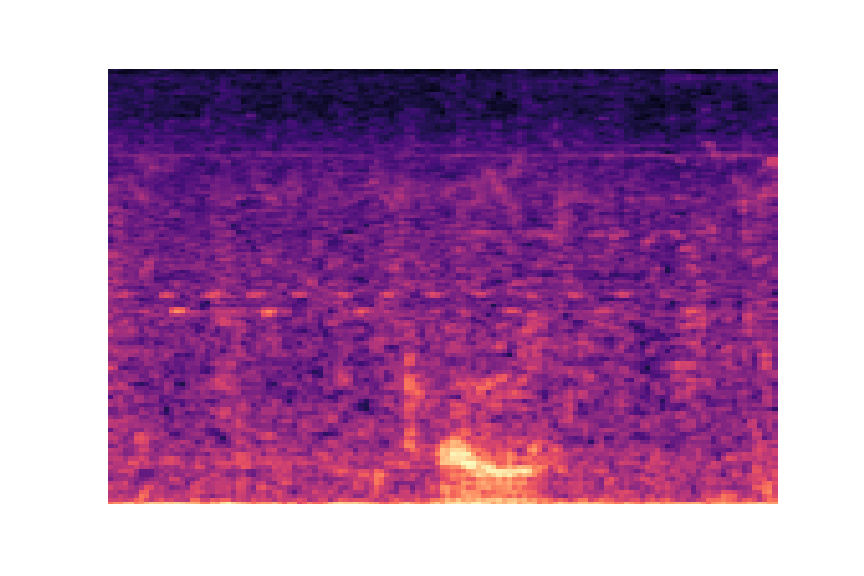

In [4]:
# Print a spectrogram
p = (path/DATA_PARAMS["SPECTROGRAM_DIR"]).ls()[2]
img = PILImage.create(p); img

In [5]:
# Get an idea of the shape, 3 color channels, 576*864 pixels
tconv = ToTensor()
img = tconv(img)
img.shape,type(img)

(torch.Size([3, 576, 864]), fastai.torch_core.TensorImage)

In [6]:
df = common.load_dz_data(DATA_PARAMS['BASE_DATA_DIR'], target_col ="age") 
df.head()

,unique_ID,call_type,comb,in_analysis,final_cat,final_subcat,distress,age,sex,agsex,path,exists,rumble_id,agecat
0,opp_330_ru,ru,n,y,nrs,nrs,na,juv,un,un,../data/metadata/spectrograms/opp_330_ru.png,True,330,inf/juv
1,opp_332_ru,ru,n,y,logistics,leave,na,ad,f,adf,../data/metadata/spectrograms/opp_332_ru.png,True,332,ad/sa
2,opp_333_ru,ru,n,y,unspecific,unspecific,na,ad,f,adf,../data/metadata/spectrograms/opp_333_ru.png,True,333,ad/sa
3,opp_333_ru1,ru,n,y,unspecific,unspecific,na,ad,f,adf,../data/metadata/spectrograms/opp_333_ru1.png,True,333,ad/sa
4,opp_333_ru2,ru,n,y,unspecific,unspecific,na,ad,f,adf,../data/metadata/spectrograms/opp_333_ru2.png,True,333,ad/sa


In [7]:
#Check all files in file exist as spectrograms
assert np.sum(df.exists) == len(df)

## Create Test set and cross-validation folds based on demographic characteristic

The rationale here is that we can have separate test sets that follow the distribution of the population depending on demographic characteristic of interest. 
This allows us to use more of the data. The balanced folds also allows cross-validation to be more representantive of the data distribution.


### Analysis for Age class prediction

We will follow a 80/20 Train/Test set. 
We also noticed missclasification between groups close in age so we will change this multiclass problem into a binary classification problem by grouping aduts/small adults and infants/juveniles

In [8]:
set(df.age.values)

{'ad', 'inf', 'juv', 'sa'}

In [9]:
test_split.TestSplitter(DATA_PARAMS).get_no_leakage_trainval_test_splits()

(array([139,  87, 279,  61,  62, 320,  30,  31, 166, 167, 273, 175, 176,
        177, 178, 179, 180, 235,   2,   3,   4, 258, 259, 260, 131, 132,
        133,  54, 150, 212, 329, 330, 331, 332, 333, 300, 233, 335, 198,
        246, 247,  90,  91,  92, 261, 262, 263, 264, 265, 228, 302, 215,
         96,  97,  98,  99, 100, 101, 207, 208, 299, 346, 211, 314, 315,
        221, 222, 162, 163,  46,  18,  19, 155, 156, 157, 158, 159, 160,
        161,  23,  24,  67, 305, 306, 307, 308, 309, 213,  68,  69,  70,
        296, 128,  86,  28, 274, 352, 353, 318, 319, 282,  20, 134, 149,
         53, 257, 195, 196,  41, 248, 191, 192, 129, 130, 145, 272,  16,
         40, 347, 348, 349, 350, 121, 244, 154, 287,   1,  34,  35, 280,
        286, 122,  15, 301, 119, 206,  57,  58,  59,  60, 336, 171, 172,
        186, 104, 105, 251, 252, 268, 275, 256, 138,  93,  94,  95,  42,
        303, 340, 341, 304, 327, 328, 209, 351, 321, 288, 266, 267, 324,
        281, 123,   6,  55, 118, 337,   0, 124, 125

In [10]:
# Create folds
train_val_indices = get_train_val_indices(DATA_PARAMS)
cross_validation.CrossValidator(
    DATA_PARAMS).get_no_leakage_crossval_splits(train_val_indices)

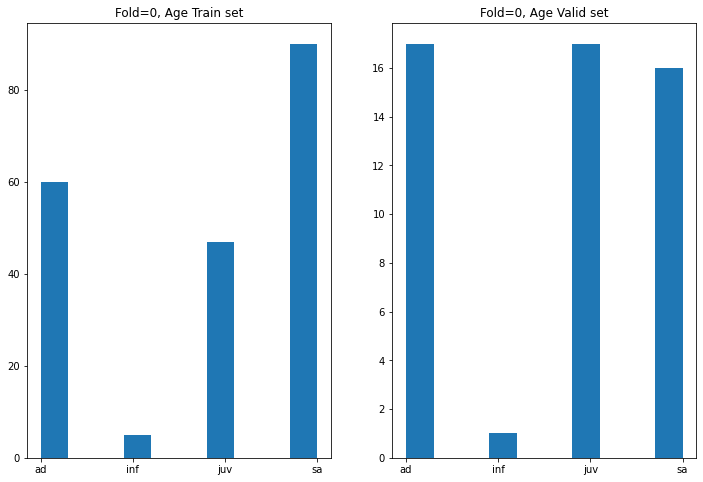

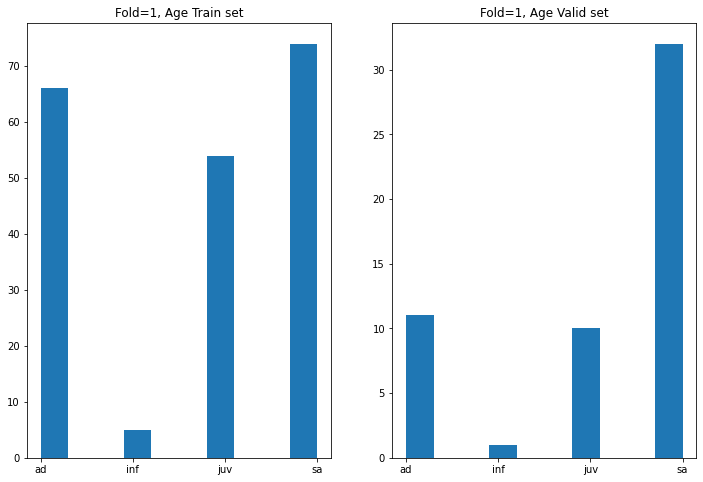

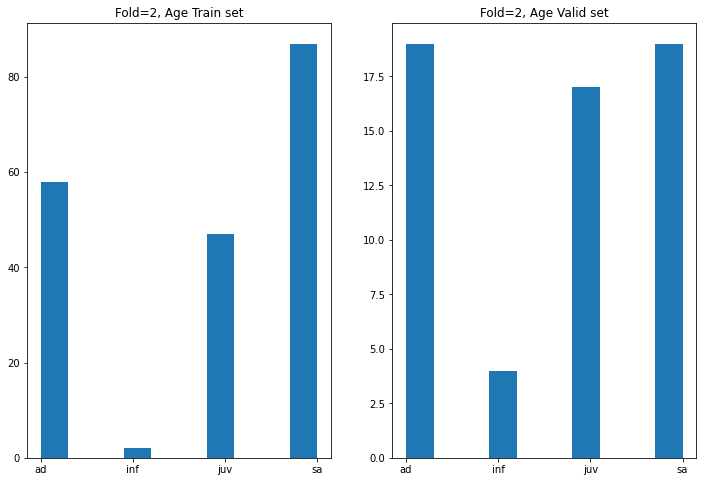

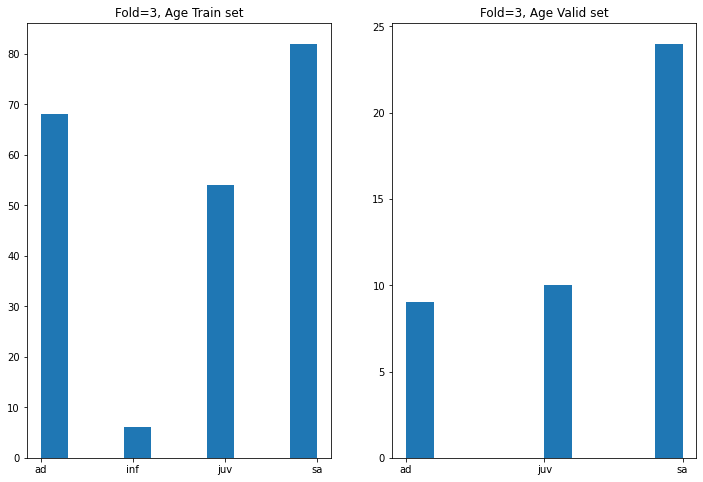

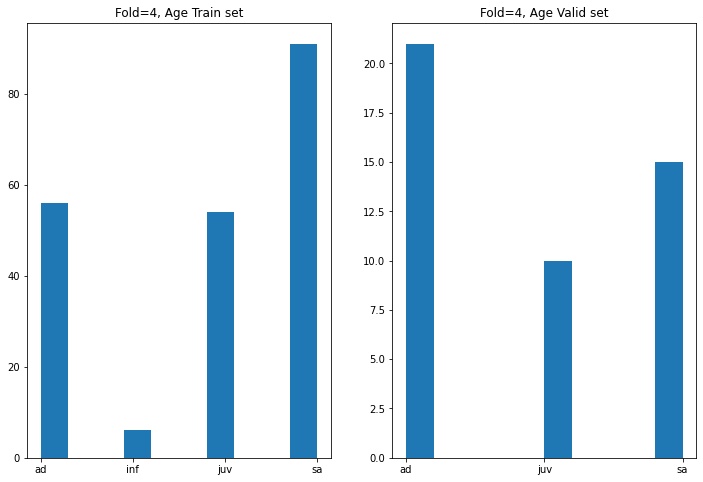

In [11]:
for fold, (tr_idx, vl_idx) in enumerate(fold_gen(DATA_PARAMS)):
    df_train = df[df.index.isin(tr_idx)].reset_index(drop=True)
    df_valid = df[df.index.isin(vl_idx)].reset_index(drop=True)
    plt.subplot(1, 2, 1)
    plt.title(f"Fold={fold}, Age Train set")
    plt.hist(sorted(df_train["age"]))
    plt.subplot(1, 2, 2)
    plt.title(f"Fold={fold}, Age Valid set")
    plt.hist(sorted(df_valid["age"]))
    plt.show()

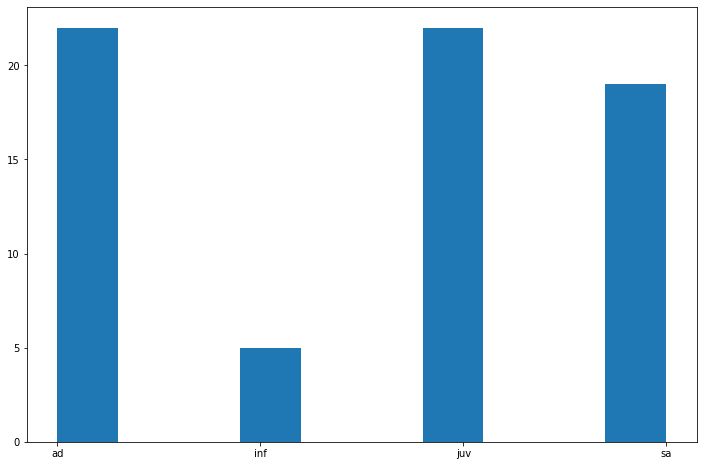

In [12]:
test_df = df[df.index.isin(get_test_indices(DATA_PARAMS))]
plt.hist(sorted(test_df["age"]))
plt.show()

## Fitting the model



In [13]:
train_val_df = df[df.index.isin(train_val_indices)].reset_index(drop=True)
train_val_df.head()
df_train = train_val_df[["path","age"]]
df_test = test_df[["path","age"]]
df_train.head()

,path,age
0,../data/metadata/spectrograms/opp_330_ru.png,juv
1,../data/metadata/spectrograms/opp_332_ru.png,ad
2,../data/metadata/spectrograms/opp_333_ru.png,ad
3,../data/metadata/spectrograms/opp_333_ru1.png,ad
4,../data/metadata/spectrograms/opp_333_ru2.png,ad


In [14]:
df_test.head()

,path,age
5,../data/metadata/spectrograms/opp_334_ru.png,ad
8,../data/metadata/spectrograms/opp_338_ru.png,ad
25,../data/metadata/spectrograms/opp_363_ru.png,ad
32,../data/metadata/spectrograms/opp_381_ru.png,juv
33,../data/metadata/spectrograms/opp_381_ru1.png,juv


In [20]:
MODEL_PARAMS = {
    "TARGET" : "age",
    "LIBRARY": "fastai",
    "EPOCHS": 10,
    "BATCH_SIZE": 10,
    "TRANSFORMATIONS" : ["Resize"],
    "PATIENCE": 3,
    "PRETRAINED": "resnet152",
    "FOLDS": DATA_PARAMS["NUM_K_FOLDS"], 
    "SEED":DATA_PARAMS["SEED"], 
    
}

FOLD=0================


/home/karma/Projects/zambezi/capstone_project/notebooks/../utils/fastai_train.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["is_valid"] = df_train.index.isin(vl_idx)


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,2.527798,2.315581,0.406250,0.593750,00:05


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,2.527239,1.908508,0.437500,0.562500,00:07
1,1.946301,1.721644,0.500000,0.500000,00:07
2,1.801560,1.798091,0.468750,0.531250,00:07
3,1.636817,1.685589,0.500000,0.500000,00:07
4,1.316647,1.811914,0.562500,0.437500,00:07
5,1.017726,1.362976,0.656250,0.343750,00:07
6,0.838339,1.015804,0.593750,0.406250,00:07
7,0.661899,1.245696,0.625000,0.375000,00:07
8,0.491482,1.275130,0.625000,0.375000,00:07
9,0.383690,1.279858,0.625000,0.375000,00:07


/home/karma/Projects/zambezi/capstone_project/notebooks/../utils/fastai_utils.py:31: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.client.log_metric(self.run_id, metric_name, np.float(val))


No improvement since epoch 6: early stopping


FOLD=1================


/home/karma/Projects/zambezi/capstone_project/notebooks/../utils/fastai_train.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["is_valid"] = df_train.index.isin(vl_idx)


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,2.610044,2.092294,0.377778,0.622222,00:05


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,2.222131,1.840933,0.511111,0.488889,00:07
1,1.901336,2.133090,0.444444,0.555556,00:07
2,1.723268,1.829214,0.577778,0.422222,00:07
3,1.590310,2.022969,0.488889,0.511111,00:07
4,1.421367,3.049407,0.444444,0.555556,00:07
5,1.175450,1.854456,0.577778,0.422222,00:07


/home/karma/Projects/zambezi/capstone_project/notebooks/../utils/fastai_utils.py:31: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.client.log_metric(self.run_id, metric_name, np.float(val))


No improvement since epoch 2: early stopping


FOLD=2================


/home/karma/Projects/zambezi/capstone_project/notebooks/../utils/fastai_train.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["is_valid"] = df_train.index.isin(vl_idx)


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,2.435367,2.302804,0.325581,0.674419,00:05


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.987272,2.042737,0.325581,0.674419,00:07
1,1.627801,2.335958,0.395349,0.604651,00:07
2,1.519500,3.395242,0.465116,0.534884,00:07
3,1.311807,2.325857,0.488372,0.511628,00:07


/home/karma/Projects/zambezi/capstone_project/notebooks/../utils/fastai_utils.py:31: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.client.log_metric(self.run_id, metric_name, np.float(val))


No improvement since epoch 0: early stopping


FOLD=3================


/home/karma/Projects/zambezi/capstone_project/notebooks/../utils/fastai_train.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["is_valid"] = df_train.index.isin(vl_idx)


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,2.301594,2.034818,0.512821,0.487179,00:05


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,2.168982,1.241465,0.666667,0.333333,00:07
1,1.780639,1.702863,0.461538,0.538462,00:07
2,1.581144,4.653697,0.333333,0.666667,00:07
3,1.659151,1.341101,0.615385,0.384615,00:07


/home/karma/Projects/zambezi/capstone_project/notebooks/../utils/fastai_utils.py:31: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.client.log_metric(self.run_id, metric_name, np.float(val))


No improvement since epoch 0: early stopping


FOLD=4================


/home/karma/Projects/zambezi/capstone_project/notebooks/../utils/fastai_train.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["is_valid"] = df_train.index.isin(vl_idx)


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,2.457791,2.901146,0.380952,0.619048,00:05


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.852844,2.111932,0.523810,0.476190,00:07
1,1.654829,2.222161,0.523810,0.476190,00:07
2,1.605386,3.255147,0.476190,0.523810,00:07
3,1.509480,1.770807,0.619048,0.380952,00:07
4,1.229186,1.625713,0.595238,0.404762,00:07
5,1.037767,1.571937,0.666667,0.333333,00:07
6,0.872866,1.385046,0.666667,0.333333,00:07
7,0.649597,1.871565,0.595238,0.404762,00:07
8,0.479739,1.654732,0.571429,0.428571,00:07
9,0.406534,1.754508,0.571429,0.428571,00:07


/home/karma/Projects/zambezi/capstone_project/notebooks/../utils/fastai_utils.py:31: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.client.log_metric(self.run_id, metric_name, np.float(val))


No improvement since epoch 6: early stopping


Summary Results
{'valid_accuracy': 0.572,
 'valid_ad_f1-score': 0.667,
 'valid_ad_precision': 0.672,
 'valid_ad_recall': 0.661,
 'valid_ad_support': 62,
 'valid_inf_f1-score': 0.2,
 'valid_inf_precision': 0.2,
 'valid_inf_recall': 0.2,
 'valid_inf_support': 5,
 'valid_juv_f1-score': 0.471,
 'valid_juv_precision': 0.421,
 'valid_juv_recall': 0.533,
 'valid_juv_support': 45,
 'valid_macro avg_f1-score': 0.481,
 'valid_macro avg_precision': 0.48,
 'valid_macro avg_recall': 0.486,
 'valid_macro avg_support': 201,
 'valid_sa_f1-score': 0.587,
 'valid_sa_precision': 0.628,
 'valid_sa_recall': 0.551,
 'valid_sa_support': 89,
 'valid_weighted avg_f1-score': 0.576,
 'valid_weighted avg_precision': 0.585,
 'valid_weighted avg_recall': 0.572,
 'valid_weighted avg_support': 201}
{'test_accuracy': 0.538,
 'test_ad_f1-score': 0.685,
 'test_ad_precision': 0.698,
 'test_ad_recall': 0.673,
 'test_ad_support': 110,
 'test_inf_f1-score': 0.118,
 'test_inf_precision': 0.222,
 'test_inf_recall': 0.08,
 'te

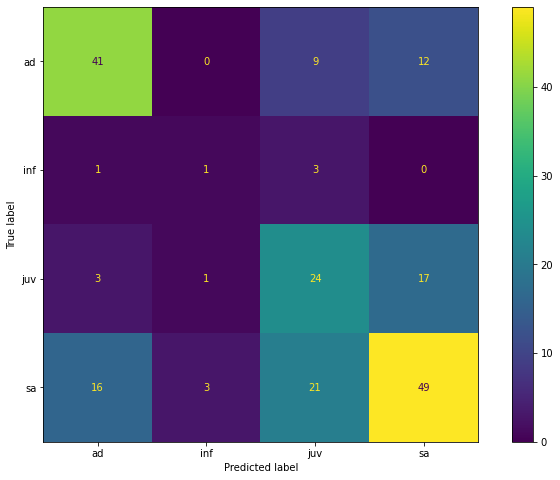

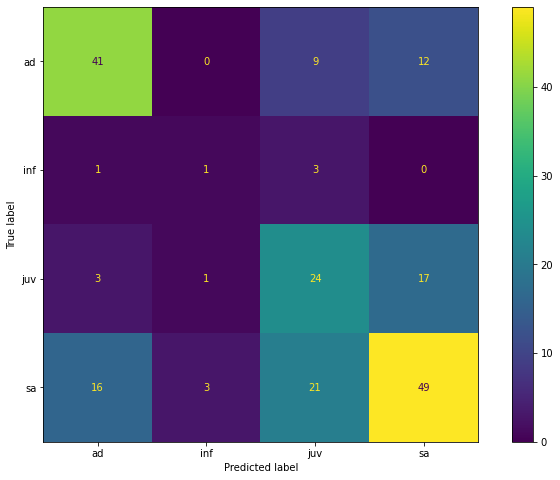

In [21]:
mlflow_experiment = MLFlowExperiment("4-class-age")            
train(DATA_PARAMS, MODEL_PARAMS, df_train, df_test, experiment=mlflow_experiment, validation_results=True)

## Model performance and diagnostics



### TODO: Next steps
- We have very few examples of infants, and most of the images we have are unlabelled, need to see if researchers can label more of the existing images. Only 354 out of 862 images are available for this analysis
- Mel spectrogram may need tweaking with different parameters SR, can check with Peter and go back to previous project15 values used
- Data augmentation has not been attempted, need to see how we can change the audio files to make sounds appear closer or further away, this will allow us to greatly scale up our training data
- Next model can be fitted using pytorch and making use of the audio layer to avoid creating mel spectrograms externally, this should prevent data loss
- Provide a CAM analysis so researchers can see why our models behave the way they do, eg: why does the model think this is a male etc..
- Share our initial finding and deployed model with the researchers in the form of a webapp that they can provide their initial feedback on.

In [17]:
def predict_from_image_paths(paths, model=learn):
    return list(map(lambda x: model.predict(PILImage.create(x))[0], paths))

# Test set values
preds = predict_from_image_paths(df_test.path.values)

NameError: name 'learn' is not defined

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(df_test.age.values, preds))

# Old split method

In [ ]:
import pandas as pd
df = pd.read_csv(path/PARAMS["BASE_DATA_DIR"]/"categorized_data.csv", index_col=0)
print(len(df))

# Removing consecutive rumble ids to under-represent accuracy    
temp = df["unique_ID"].str.split("_", n = 3, expand = True)
df["id"] = temp[1]
df=df.drop_duplicates(subset = ["id"])
print(len(df))
df.head()

In [ ]:
from sklearn.model_selection import train_test_split
def train_test_splits(df, y_col="age", seed=42,  val_size=.2,test_size=.2, save=True):
    X = df[df[y_col]!="un"].reset_index(drop=True)
    y = X[y_col]

 
    
    # Split original dataframe into train and temp dataframes.
    df_train, df_test, y_train, y_test = train_test_split(X,
                                                          y,
                                                          stratify=y,
                                                          test_size=test_size,
                                                          random_state=seed)   

    vs = test_size/(1-test_size)
    # Split original dataframe into train and temp dataframes.
    df_train, df_val, y_train, y_val = train_test_split(df_train,
                                                          y_train,
                                                          stratify=y_train,
                                                          test_size=vs,
                                                          random_state=seed)   
    df_train["is_valid"] = False
    df_val["is_valid"] = True

    df_final = pd.concat([df_train, df_val]).reset_index(drop=True)
 
 
    print(f"Training Size: {len(df_train)}, Validation Size: {len(df_val)}, Test Size: {len(df_test)} ")
        
    return df_final,  df_test

In [ ]:
df_train, df_test = train_test_splits(df)

df_train.head()

In [ ]:

df_test = df_test[["path","age"]]
df_train = df_train[["path","age","is_valid"]]
df_train.head()

In [ ]:
plt.subplot(1, 4, 1)
plt.title("Age train set")
plt.hist(sorted(df_train.loc[ (df_train.is_valid==False),"age"]))
plt.subplot(1, 4, 2)
plt.title("Age valid set")
plt.hist(sorted(df_train.loc[df_train.is_valid,"age"]))
plt.subplot(1, 4, 3)
plt.title("Age test set")
plt.hist(sorted(df_test["age"]))
plt.subplot(1, 4, 4)
plt.title("Age population")
plt.hist(sorted(df["age"]))
plt.show()

In [ ]:
%%script echo skipping
from datetime import datetime
from IPython.display import display  

class ExperimentLogger:
    """Helper class to write metrics to results.csv"""
    def __init__(self, model_name, targets=None, preds=None, experiments_path="../reports/experiments.csv", notes = ""):
        self.model_name = model_name
        self.timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        self.model_id = self.model_name + '_' + self.timestamp
        self.notes = notes
        self.experiments_path = experiments_path
        self.experiments = pd.read_csv(experiments_path)
        results = Metrics(targets, preds).score()
        attrs = {
                "Model": self.model_name,
                "Datetime": self.timestamp,
                "Model_id": self.model_id,
                "Notes" : self.notes
            }
        attrs.update(results)
        self.results_df = pd.DataFrame(attrs, index=[0])
        

    def view_current_results(self):
        display(self.results_df)
        
    def view_all_history(self):
        display(experiments)
        
    def view_model_history(self):
        display(self.experiments.loc[self.experiments.Model == self.model_name])
        
    def log_result(self):
        with open(self.experiments_path, mode = 'a') as f:
            self.results_df.to_csv(f, header=f.tell()==0,index = False)

        

    

experiment = ExperimentLogger("baseline-models-4-age-class", x,z,notes="Test Save")
#Preview results
experiment.view_current_results()

# How does it compare to the other models
experiment.view_model_history()

# Save the results
experiment.log_result()

# Save the model
print(experiment.model_id)
    

In [ ]:
%%script echo skipping
#Preview results
experiment.view_current_results()



In [ ]:
%%script echo skipping
# How does it compare to the other models
experiment.view_model_history()


In [ ]:
%%script echo skipping
# Save the results
experiment.log_result()

# Save the model
print(experiment.model_id)